In [18]:
!pip install matplotlib seaborn joblib lightgbm

  Using cached lightgbm-4.6.0-py3-none-macosx_12_0_arm64.whl (1.6 MB)
  Using cached scipy-1.13.1-cp39-cp39-macosx_12_0_arm64.whl (30.3 MB)

[notice] A new release of pip is available: 23.0.1 -> 25.2
[notice] To update, run: pip install --upgrade pip



                      詳細評価結果 (全カテゴリ)
                                          MAPE  SD_of_APEs  P95_Error
Model                  category                                      
Kernel-centric         Seen              18.00       17.13      55.19
                       Unseen (A100)     43.65       23.77      81.02
                       Unseen (RTX 4070) 25.01       20.90      66.22
Catalog Spec           Seen               0.93        2.49       3.41
                       Unseen (A100)     32.96       24.49      71.57
                       Unseen (RTX 4070) 15.94       13.88      44.73
CTFusion (Device Only) Seen               0.83        1.68       2.78
                       Unseen (A100)     34.97       26.08      74.78
                       Unseen (RTX 4070) 14.61       17.26      54.69
CTFusion (w/o SBV)     Seen               0.67        1.66       2.39
                       Unseen (A100)     30.57       26.53      72.30
                       Unseen (RTX 4070) 15.33      

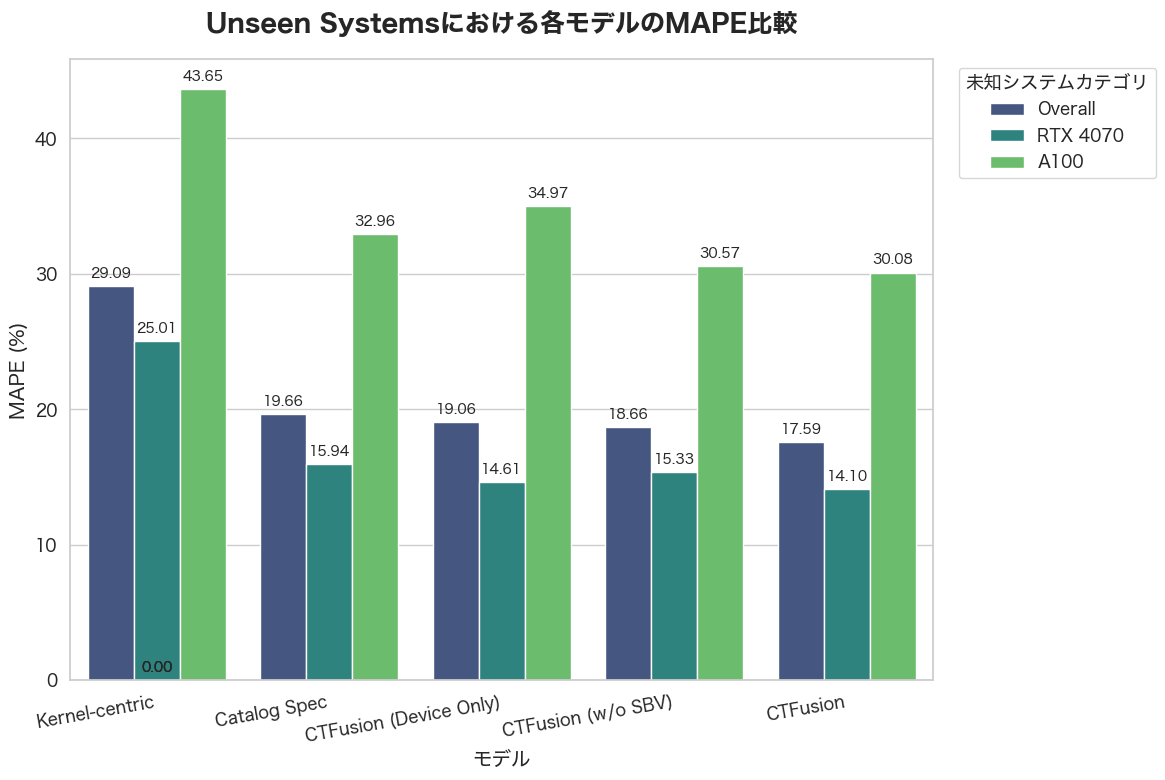

In [9]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 設定 ---
STGC_EVAL_OUTPUTS_DIR = Path("../experiments/outputs")

# 論文で表示したいモデルの順序を定義
MODELS_IN_ORDER = [
    "Kernel-centric",
    "Catalog Spec",
    "CTFusion (Device Only)",
    "CTFusion (w/o SBV)",
    "CTFusion", # 提案手法を最後に
]

# モデル名とディレクトリのマッピング
MODEL_DIRS = {
    "CTFusion": "exp001_holdout_ctfusion_20250715_163234",
    "Kernel-centric": "exp002_holdout_baseline_kernel_centric_20250721_185505",
    "Catalog Spec": "exp003_holdout_baseline_catalog_spec_20250721_223721",
    "CTFusion (Device Only)": "exp004_holdout_ablation_device_only_20250722_000209",
    "CTFusion (w/o SBV)": "exp005_holdout_ablation_without_interaction_20250721_231059",
}

UNKNOWN_SYSTEMS = [
    "intel_xeon_gold_6330__nvidia_a100_pcie_40gb",  
    "intel_core_i5_13th_gen__nvidia_geforce_rtx_4070",
    "intel_core_i7_9th_gen__nvidia_geforce_rtx_4070",
    "intel_core_i7_13th_gen__nvidia_geforce_rtx_4070", 
    "intel_xeon_gold_5122__nvidia_geforce_rtx_4070",
]
PREDICTIONS_FILENAME = "predictions_all.csv"

# --- 2. 全モデルの予測データを読み込み、結合 ---
# ※ このセクションは変更ありません
all_preds_list = []
for model_name in MODELS_IN_ORDER:
    output_dir = MODEL_DIRS.get(model_name)
    if not output_dir:
        print(f"警告: モデル '{model_name}' のディレクトリ設定が見つかりません。")
        continue
    
    path = STGC_EVAL_OUTPUTS_DIR / output_dir / PREDICTIONS_FILENAME
    if path.exists():
        df = pd.read_csv(path)
        df['Model'] = model_name
        all_preds_list.append(df)
    else:
        print(f"警告: {path} が見つかりません。スキップします。")

if not all_preds_list:
    print("エラー: 評価対象の予測ファイルが一つも見つかりませんでした。")
    exit()

df_all = pd.concat(all_preds_list, ignore_index=True)
df_all['ape_pct'] = df_all['ape'] * 100


# --- 3. 詳細評価テーブル (カテゴリ別) の作成と表示 ---
# カテゴリ分け
df_all['category'] = np.where(df_all['system_id'].isin(UNKNOWN_SYSTEMS), 'Unseen', 'Seen')
df_all.loc[(df_all['category'] == 'Unseen') & (df_all['system_id'].str.contains('a100')), 'category'] = 'Unseen (A100)'
df_all.loc[(df_all['category'] == 'Unseen') & (df_all['system_id'].str.contains('rtx_4070')), 'category'] = 'Unseen (RTX 4070)'

grouped_results = df_all.groupby(['Model', 'category'])['ape_pct'].agg(
    MAPE='mean',
    SD_of_APEs='std',
    P95_Error=lambda x: x.quantile(0.95)
)

print("\n" + "="*80)
print("                      詳細評価結果 (全カテゴリ)")
print("="*80)
print(grouped_results.reindex(MODELS_IN_ORDER, level='Model').to_string(float_format="%.2f"))


# --- 4. 論文用サマリーテーブル (未知セット全体 + 内訳) の作成と表示 ---
df_unseen = df_all[df_all['category'].str.startswith('Unseen')]

# [改善点] `aggfunc`に文字列 'mean' を指定し、FutureWarningを解消しました。
mape_pivot = df_unseen.pivot_table(
    index='Model',
    columns='category',
    values='ape_pct',
    aggfunc='mean'
)
# Unseen全体を追加
mape_pivot['Overall'] = df_unseen.groupby('Model')['ape_pct'].mean()
# 列の順序を整える
mape_pivot = mape_pivot[['Overall', 'Unseen (RTX 4070)', 'Unseen (A100)']]
mape_pivot.columns = ['MAPE (Overall) [%]', 'MAPE (RTX 4070) [%]', 'MAPE (A100) [%]']


overall_stats = df_unseen.groupby('Model')['ape_pct'].agg(
    SD_of_MAPEs='std',
    P95_APE=lambda x: x.quantile(0.99)
)
overall_stats.columns = ['SD of MAPEs (Overall) [%]', 'P95 APE (Overall) [%]']

# 2つのデータフレームを結合
summary_table = mape_pivot.join(overall_stats)

print("\n" + "="*95)
print("                         論文用サマリーテーブル (未知セット全体 + カテゴリ別MAPE内訳)")
print("="*95)
print(summary_table.reindex(MODELS_IN_ORDER).to_string(float_format="%.2f"))


# --- 5. [追加] 論文用サマリーテーブルの可視化 ---
# スタイル設定 (お好みに合わせて変更してください)
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Hiragino Sans', 'Yu Gothic', 'Meiryo', 'TakaoPGothic', 'IPAexGothic', 'Noto Sans CJK JP']


# プロット用にデータを準備
plot_data = summary_table.reindex(MODELS_IN_ORDER).reset_index()
# 'melt' を使って、カテゴリごとのMAPEをプロットしやすい形式（縦長）に変換
plot_data_melted = plot_data.melt(
    id_vars='Model',
    value_vars=['MAPE (Overall) [%]', 'MAPE (RTX 4070) [%]', 'MAPE (A100) [%]'],
    var_name='Category',
    value_name='MAPE [%]'
)
# カテゴリ名の見栄えを調整
plot_data_melted['Category'] = plot_data_melted['Category'].str.replace('MAPE \(|\) \[%\]', '', regex=True).str.strip()


# 棒グラフの作成
plt.figure(figsize=(14, 8))
ax = sns.barplot(
    data=plot_data_melted,
    x='Model',
    y='MAPE [%]',
    hue='Category',
    order=MODELS_IN_ORDER, # モデルの順序を維持
    palette='viridis' # 配色
)

# グラフの装飾
ax.set_title('Unseen Systemsにおける各モデルのMAPE比較', fontsize=18, fontweight='bold', pad=20)
ax.set_xlabel('モデル', fontsize=14)
ax.set_ylabel('MAPE (%)', fontsize=14)
plt.xticks(rotation=10, ha='right') # X軸ラベルが重ならないように少し回転
ax.legend(title='未知システムカテゴリ', bbox_to_anchor=(1.02, 1), loc='upper left')

# 棒グラフの上に数値を表示
for p in ax.patches:
    ax.annotate(f'{p.get_height():.2f}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                xytext=(0, 9),
                textcoords='offset points',
                fontsize=10)

plt.tight_layout(rect=[0, 0, 0.85, 1]) # 凡例が収まるようにレイアウト調整
plt.show()



In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path

# --- 1. 設定 ---
STGC_EVAL_OUTPUTS_DIR = Path("../experiments/outputs")

# 分析したいモデルの順序を定義
MODELS_IN_ORDER = [
    "Kernel-centric",
    "Catalog Spec",
    "CTFusion (Device Only)",
    "CTFusion (w/o SBV)",
    "CTFusion",
]

# モデル名とディレクトリのマッピング
MODEL_DIRS = {
    "CTFusion": "exp001_holdout_ctfusion_20250715_163234",
    "Kernel-centric": "exp002_holdout_baseline_kernel_centric_20250721_185505",
    "Catalog Spec": "exp003_holdout_baseline_catalog_spec_20250721_223721",
    "CTFusion (Device Only)": "exp004_holdout_ablation_device_only_20250722_000209",
    "CTFusion (w/o SBV)": "exp005_holdout_ablation_without_interaction_20250721_231059",
}

# 分析対象のハードウェア (未知セット)
UNKNOWN_SYSTEMS = [
    "intel_xeon_gold_6330__nvidia_a100_pcie_40gb",  
    "intel_core_i5_13th_gen__nvidia_geforce_rtx_4070",
    "intel_core_i7_9th_gen__nvidia_geforce_rtx_4070",
    "intel_core_i7_13th_gen__nvidia_geforce_rtx_4070", 
    "intel_xeon_gold_5122__nvidia_geforce_rtx_4070",
]
PREDICTIONS_FILENAME = "predictions_all.csv"

# --- 2. データロード & 準備 ---
all_preds_list = []
# (ここは前回のスクリプトと同じ)
for model_name in MODELS_IN_ORDER:
    output_dir = MODEL_DIRS.get(model_name)
    if not output_dir: continue
    path = STGC_EVAL_OUTPUTS_DIR / output_dir / PREDICTIONS_FILENAME
    if path.exists():
        df = pd.read_csv(path)
        df['Model'] = model_name
        all_preds_list.append(df)
df_all = pd.concat(all_preds_list, ignore_index=True)

# 未知セットのデータのみを対象
df_unseen = df_all[df_all['system_id'].isin(UNKNOWN_SYSTEMS)].copy()


# --- 3. 過小評価と過大評価の誤差を計算 ---
# error = preds - target なので:
# error < 0  =>  preds < target  => 過小評価 (Under-prediction)
# error > 0  =>  preds > target  => 過大評価 (Over-prediction)

# パーセント誤差 (PE) を計算。APEと違い、符号を保持する
denominator = df_unseen['target'].copy()
denominator[denominator <= 0] = 1e-9 # ゼロ除算防止
df_unseen['pe'] = (df_unseen['error'] / denominator) * 100 # %表記

# 過小評価データと過大評価データに分割
df_under = df_unseen[df_unseen['error'] < 0].copy()
df_over = df_unseen[df_unseen['error'] > 0].copy()

# 過小評価誤差（マイナス）の絶対値を取る
# 例: -30% の誤差は 30% の過小評価誤差として扱う
df_under['under_pe'] = np.abs(df_under['pe'])

# 過大評価誤差はそのまま（プラス）
df_over['over_pe'] = df_over['pe']


# --- 4. モデルごとに各指標を計算 ---
results = []
for model_name in MODELS_IN_ORDER:
    
    # 該当モデルのデータをフィルタリング
    model_under_data = df_under[df_under['Model'] == model_name]
    model_over_data = df_over[df_over['Model'] == model_name]
    
    # 計算するパーセンタイル
    percentiles = [0.95, 0.99]
    
    # 過小評価のパーセンタイル
    under_percentiles = model_under_data['under_pe'].quantile(percentiles) if not model_under_data.empty else pd.Series(index=percentiles, dtype=float)
    
    # 過大評価のパーセンタイル
    over_percentiles = model_over_data['over_pe'].quantile(percentiles) if not model_over_data.empty else pd.Series(index=percentiles, dtype=float)
    
    results.append({
        'Model': model_name,
        'Under-P95 Error [%]': under_percentiles.loc[0.95],
        'Under-P99 Error [%]': under_percentiles.loc[0.99],
        'Over-P95 Error [%]': over_percentiles.loc[0.95],
        'Over-P99 Error [%]': over_percentiles.loc[0.99],
    })

# --- 5. 結果の表示 ---
df_results = pd.DataFrame(results).set_index('Model')

print("\n" + "="*80)
print("     予測バイアス分析: 過小評価・過大評価のワーストケース誤差 (Unseenセット)")
print("="*80)
print(df_results.to_string(float_format="%.2f"))
print("-" * 80)
print("Under-P95 Error: 95%の『過小評価』はこの誤差の範囲内に収まることを示す。")
print("Over-P95 Error:  95%の『過大評価』はこの誤差の範囲内に収まることを示す。")
print("※ 低い方が、その方向への極端なエラーが少ないことを意味する。")


     予測バイアス分析: 過小評価・過大評価のワーストケース誤差 (Unseenセット)
                        Under-P95 Error [%]  Under-P99 Error [%]  Over-P95 Error [%]  Over-P99 Error [%]
Model                                                                                                   
Kernel-centric                        72.68                83.27               53.53               71.89
Catalog Spec                          70.59                76.63               45.43               62.91
CTFusion (Device Only)                61.60                76.68               62.51               93.51
CTFusion (w/o SBV)                    70.76                81.44               48.21               64.93
CTFusion                              64.02                70.77               40.09               50.09
--------------------------------------------------------------------------------
Under-P95 Error: 95%の『過小評価』はこの誤差の範囲内に収まることを示す。
Over-P95 Error:  95%の『過大評価』はこの誤差の範囲内に収まることを示す。
※ 低い方が、その方向への極端なエラーが少ないことを意味する。


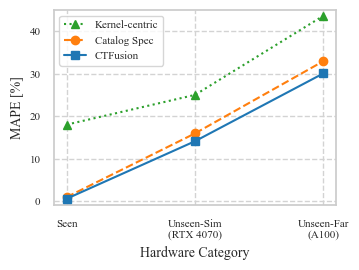

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. データを直接入力（よりシンプルな形式に修正） ---
# DataFrameにしやすいように、1行ずつのリストとしてデータを用意します。
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
data = [
    # Model, category, MAPE
    ['Kernel-centric', 'Seen', 18.00],
    ['Kernel-centric', 'Unseen (RTX 4070)', 25.01],
    ['Kernel-centric', 'Unseen (A100)', 43.65],
    
    ['Catalog Spec', 'Seen', 0.93],
    ['Catalog Spec', 'Unseen (RTX 4070)', 15.94],
    ['Catalog Spec', 'Unseen (A100)', 32.96],
    
    ['CTFusion', 'Seen', 0.55],
    ['CTFusion', 'Unseen (RTX 4070)', 14.10],
    ['CTFusion', 'Unseen (A100)', 30.08],
]

# データフレームを作成
df_plot_main = pd.DataFrame(data, columns=['Model', 'category', 'MAPE'])


# --- 2. スタイルと順序の定義（ここから下は変更なし） ---

# 表示順序を定義
MODELS_IN_ORDER_MAIN = ["Kernel-centric", "Catalog Spec", "CTFusion"]

# スタイルマッピング
style_map = {
    "CTFusion":         {'color': '#1f77b4', 'marker': 's', 'linestyle': '-', 'linewidth': 1.5, 'zorder': 10},
    "Catalog Spec":     {'color': '#ff7f0e', 'marker': 'o', 'linestyle': '--', 'linewidth': 1.5},
    "Kernel-centric":   {'color': '#2ca02c', 'marker': '^', 'linestyle': ':', 'linewidth': 1.5},
}

# --- 3. MAPEトレンドグラフ描画 ---
fig, ax = plt.subplots(figsize=(3.4, 2.5))
x_order = ['Seen', 'Unseen (RTX 4070)', 'Unseen (A100)']
x_labels = ['Seen', 'Unseen-Sim\n(RTX 4070)', 'Unseen-Far\n(A100)']

for model_name in MODELS_IN_ORDER_MAIN:
    model_data = df_plot_main[df_plot_main['Model'] == model_name].set_index('category').reindex(x_order)
    style = style_map.get(model_name, {}) # スタイルを取得
    ax.plot(model_data.index, model_data['MAPE'], label=model_name, **style)

ax.set_ylim(-1, 45)
ax.set_yticks(np.arange(0, 41, 10))
ax.set_ylabel('MAPE [%]', fontsize=10)
ax.set_xlabel('Hardware Category', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)
ax.set_xticks(x_order)
ax.set_xticklabels(x_labels)
ax.legend( loc='upper left', fontsize=8)
ax.grid(True, which="major", ls="--", c="lightgrey")
ax.set_facecolor('white')
plt.tight_layout(pad=0)
plt.show()

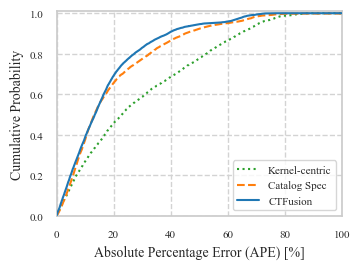

In [12]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
# --- 1. 設定 ---
STGC_EVAL_OUTPUTS_DIR = Path("../experiments/outputs")

# 論文で表示したいモデルの順序を定義
MODELS_IN_ORDER = [
    "Kernel-centric",
    "Catalog Spec",
    # "CTFusion (Device Only)",
    # "CTFusion (w/o SBV)",
    "CTFusion", # 提案手法を最後に
]

# モデル名とディレクトリのマッピング
MODEL_DIRS = {
    "CTFusion": "exp001_holdout_ctfusion_20250715_163234",
    "Kernel-centric": "exp002_holdout_baseline_kernel_centric_20250721_185505",
    "Catalog Spec": "exp003_holdout_baseline_catalog_spec_20250721_223721",
    # "CTFusion (Device Only)": "exp004_holdout_ablation_device_only_20250722_000209",
    # "CTFusion (w/o SBV)": "exp005_holdout_ablation_without_interaction_20250721_231059",
}

UNKNOWN_SYSTEMS = [
    "intel_xeon_gold_6330__nvidia_a100_pcie_40gb",  
    "intel_core_i5_13th_gen__nvidia_geforce_rtx_4070",
    "intel_core_i7_9th_gen__nvidia_geforce_rtx_4070",
    "intel_core_i7_13th_gen__nvidia_geforce_rtx_4070", 
    "intel_xeon_gold_5122__nvidia_geforce_rtx_4070",
]
PREDICTIONS_FILENAME = "predictions_all.csv"

# --- 2. 全モデルの予測データを読み込み、結合 ---
all_preds_list = []
for model_name in MODELS_IN_ORDER:
    output_dir = MODEL_DIRS.get(model_name)
    if not output_dir:
        print(f"警告: モデル '{model_name}' のディレクトリ設定が見つかりません。")
        continue
    
    path = STGC_EVAL_OUTPUTS_DIR / output_dir / PREDICTIONS_FILENAME
    if path.exists():
        df = pd.read_csv(path)
        df['Model'] = model_name
        all_preds_list.append(df)
    else:
        print(f"警告: {path} が見つかりません。スキップします。")

if not all_preds_list:
    print("エラー: 評価対象の予測ファイルが一つも見つかりませんでした。")
    exit()

df_all = pd.concat(all_preds_list, ignore_index=True)
df_all['ape_pct'] = df_all['ape'] * 100


# --- 3. 詳細評価テーブル (カテゴリ別) の作成と表示 ---
# カテゴリ分け
df_all['category'] = np.where(df_all['system_id'].isin(UNKNOWN_SYSTEMS), 'Unseen', 'Seen')
df_all.loc[(df_all['category'] == 'Unseen') & (df_all['system_id'].str.contains('a100')), 'category'] = 'Unseen (A100)'
df_all.loc[(df_all['category'] == 'Unseen') & (df_all['system_id'].str.contains('rtx_4070')), 'category'] = 'Unseen (RTX 4070)'


df_unseen = df_all[df_all['category'].str.startswith('Unseen')]

# --- 2. スタイルマッピングの定義（折れ線グラフと完全に統一） ---
# スタイルマッピング
style_map = {
    "CTFusion":         {'color': '#1f77b4', 'marker': 's', 'linestyle': '-', 'linewidth': 1.5, 'zorder': 10},
    "Catalog Spec":     {'color': '#ff7f0e', 'marker': 'o', 'linestyle': '--', 'linewidth': 1.5 },
    "Kernel-centric":   {'color': '#2ca02c', 'marker': '^', 'linestyle': ':', 'linewidth': 1.5},
}

# --- 3. CDFグラフ描画 ---
fig, ax = plt.subplots(figsize=(3.4, 2.5))

# 各モデルのCDFをプロット
for model_name in MODELS_IN_ORDER:
    # スタイルを取得（マーカーはCDFでは使わないので除外）
    current_style = {k: v for k, v in style_map.get(model_name, {}).items() if k != 'marker'}

    # モデルのAPEデータを取得し、ソート
    ape_data = df_unseen[df_unseen['Model'] == model_name]['ape_pct']
    sorted_data = np.sort(ape_data)
    
    # yvals（累積確率）を計算
    yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # プロット
    ax.plot(sorted_data, yvals, label=model_name, **current_style)

# --- 4. グラフのフォーマット調整（論文品質） ---
# 軸ラベル
ax.set_ylabel('Cumulative Probability', fontsize=10)
ax.set_xlabel('Absolute Percentage Error (APE) [%]', fontsize=10)
ax.tick_params(axis='both', which='major', labelsize=8)

# 軸の範囲と目盛り
ax.set_xlim(0, 100)
ax.set_ylim(0, 1.01)
ax.set_xticks(np.arange(0, 101, 20))
ax.set_yticks(np.arange(0, 1.1, 0.2))

# 凡例を最適な位置（右下）に配置
ax.legend(loc='lower right', fontsize=8, frameon=True)

# グリッド
ax.grid(True, which="major", ls="--", c="lightgrey")
ax.set_facecolor('white')
plt.tight_layout(pad=0)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.lines import Line2D

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
# --- 1. 設定 (変更なし) ---
MODELS_INFO = {
    "CTFusion": {"model_name": "CTFusion", "path": "../stgc_outputs/exp001_holdout_ctfusion_20250715_163234/predictions_all.csv"},
    "Kernel-centric": {"model_name": "Kernel-centric", "path": "../stgc_outputs/exp002_holdout_baseline_kernel_centric_20250721_185505/predictions_all.csv"},
    "Catalog Spec": {"model_name": "Catalog Spec", "path": "../stgc_outputs/exp003_holdout_baseline_catalog_spec_20250721_223721/predictions_all.csv"},
}
UNSEEN_HW_ORDER = [
    'intel_core_i5_13th_gen__nvidia_geforce_rtx_4070', 'intel_core_i7_9th_gen__nvidia_geforce_rtx_4070',
    'intel_core_i7_13th_gen__nvidia_geforce_rtx_4070', 'intel_xeon_gold_5122__nvidia_geforce_rtx_4070',
    'intel_xeon_gold_6330__nvidia_a100_pcie_40gb',
]
HW_DISPLAY_NAMES = {
    'intel_core_i5_13th_gen__nvidia_geforce_rtx_4070': "Core i5-13th Gen\nRTX 4070",
    'intel_core_i7_9th_gen__nvidia_geforce_rtx_4070': "Core i7-9th Gen\nRTX 4070",
    'intel_core_i7_13th_gen__nvidia_geforce_rtx_4070': "Core i7-13th Gen\nRTX 4070",
    'intel_xeon_gold_5122__nvidia_geforce_rtx_4070': "Xeon Gold 5122\nRTX 4070",
    'intel_xeon_gold_6330__nvidia_a100_pcie_40gb': "A100 40GB\n(Xeon Gold 6330)", # A100を主役にした表示
}
DL_MODEL_ORDER = ['faster_rcnn', 'ssd300', 'yolov8s', 'yolos', 'rt_detr', 'detr']
TARGET_MODELS = ["Kernel-centric", "Catalog Spec", "CTFusion"]

# --- 2. データロード関数 (変更なし) ---
def load_all_predictions(models_info, target_keys):
    all_dfs = []
    for model_key in target_keys:
        info = models_info.get(model_key)
        if not info: continue
        try:
            df = pd.read_csv(info["path"])
            df['prediction_model'] = info["model_name"]
            all_dfs.append(df)
        except FileNotFoundError: print(f"警告: ファイルが見つかりません - {info['path']}")
    return pd.concat(all_dfs, ignore_index=True)

# --- 4. グラフ描画関数 (IEEE仕様に調整) ---
def plot_unseen_comparison_grid_for_ieee(df):
    unseen_df = df[df['system_id'].isin(UNSEEN_HW_ORDER)].copy()
    unseen_df['model_name'] = pd.Categorical(unseen_df['model_name'], categories=DL_MODEL_ORDER, ordered=True)
    colors = sns.color_palette("viridis_r", n_colors=len(DL_MODEL_ORDER))
    palette_dict = {model: color for model, color in zip(DL_MODEL_ORDER, colors)}
    x_max_overall = unseen_df['target'].max() * 1.05
    y_max_overall = unseen_df['preds'].max() * 1.05
    line_max_overall = max(x_max_overall, y_max_overall)

    # figsizeとフォントサイズを全体的に縮小
    fig, axes = plt.subplots(nrows=len(TARGET_MODELS), ncols=len(UNSEEN_HW_ORDER),
                             figsize=(7.16, 5.0), sharex=True, sharey=True)

    for i, pred_model_name in enumerate(TARGET_MODELS):
        for j, hw_id in enumerate(UNSEEN_HW_ORDER):
            ax = axes[i, j]
            plot_data = unseen_df[(unseen_df['prediction_model'] == pred_model_name) & (unseen_df['system_id'] == hw_id)]
            if not plot_data.empty:
                sns.scatterplot(data=plot_data, x="target", y="preds", hue="model_name", hue_order=DL_MODEL_ORDER, palette=palette_dict, alpha=0.7, s=10, ax=ax, legend=False)
                mape = plot_data['ape'].mean() * 100
                # MAPE表示のフォントサイズを縮小
                ax.text(0.95, 0.05, f'MAPE: {mape:.1f}%', transform=ax.transAxes, fontsize=6, verticalalignment='bottom', horizontalalignment='right', bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))
            
            # 線の太さを調整
            ax.plot([0, line_max_overall], [0, line_max_overall], color='black', linestyle='--', linewidth=0.8)
            ax.plot([0, line_max_overall], [0, line_max_overall * 1.25], color='gray', linestyle=':', linewidth=0.6)
            ax.plot([0, line_max_overall], [0, line_max_overall * 0.75], color='gray', linestyle=':', linewidth=0.6)
            ax.set_xlabel("")
            ax.tick_params(axis='both', which='major', labelsize=8) # 目盛りのフォントサイズ

    plt.setp(axes, xlim=(0, x_max_overall), ylim=(0, y_max_overall))

    # ラベルとタイトルのフォントサイズ、余白を調整
    for i, pred_model_name in enumerate(TARGET_MODELS): axes[i, 0].set_ylabel(pred_model_name, fontsize=9, weight='bold', labelpad=8)
    for j, hw_id in enumerate(UNSEEN_HW_ORDER): axes[0, j].set_title(HW_DISPLAY_NAMES.get(hw_id, hw_id), fontsize=8, fontweight='bold', pad=10)

    fig.supxlabel('Actual Execution Time [ms]', fontsize=10, y=0.02)
    fig.supylabel('Predicted Execution Time [ms]', fontsize=10, x=0)

    # 凡例のフォントサイズとマーカーサイズを調整
    dot_handles = [Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=palette_dict[label], markersize=5) for label in DL_MODEL_ORDER]
    leg1 = fig.legend(handles=dot_handles, labels=DL_MODEL_ORDER, title='DL Model', bbox_to_anchor=(0.97, 0.7), loc='upper right', fontsize=8, title_fontsize=9)
    
    line_handles = [Line2D([0], [0], color='black', linestyle='--', linewidth=1), Line2D([0], [0], color='gray', linestyle=':', linewidth=1)]
    leg2 = fig.legend(handles=line_handles, labels=['Ideal (y = x)', '± 25% Error'], title='Reference Lines', bbox_to_anchor=(0.98, 0.45), loc='upper right', fontsize=8, title_fontsize=9)
    
    # ★★★ レイアウト調整: 凡例スペースを確保し、上下の余白を調整 ★★★
    plt.subplots_adjust(left=0.1, right=0.84, top=0.88, bottom=0.12, hspace=0.25, wspace=0.15)

    # 縦線の位置と太さを調整
    pos4 = axes[0, 3].get_position()
    pos5 = axes[0, 4].get_position()
    line_x_coord = (pos4.x1 + pos5.x0) / 2
    line = plt.Line2D([line_x_coord, line_x_coord], [0.12, 0.88], transform=fig.transFigure, color='black', linestyle='--', linewidth=1.5)
    fig.add_artist(line)

    # ★★★ 上位カテゴリ名のY座標を、確保した余白に配置 ★★★
    pos1 = axes[0, 0].get_position()
    sim_x_coord = (pos1.x0 + pos4.x1) / 2
    fig.text(sim_x_coord, 0.98, 'Unseen-Sim', ha='center', va='center', fontsize=10, weight='bold', bbox=dict(boxstyle='round,pad=0.2', fc='lightblue', alpha=0.5))
    
    far_x_coord = (pos5.x0 + pos5.x1) / 2
    fig.text(far_x_coord, 0.98, 'Unseen-Far', ha='center', va='center', fontsize=10, weight='bold', bbox=dict(boxstyle='round,pad=0.2', fc='#E8A87C', alpha=0.5))

    plt.show()


# --- 5. メインの処理 ---
if __name__ == '__main__':    
    # データをロードしてプロット
    all_preds_df = load_all_predictions(MODELS_INFO, TARGET_MODELS)
    if not all_preds_df.empty:
        plot_unseen_comparison_grid_for_ieee(all_preds_df)


: 

--- Top 10 Feature Importances (Gain, Normalized) ---
               feature_display  importance_normalized
                n_frames (TDV)              18.732159
     pcie_demand_dynamic (SBV)              16.098717
         roofline_static (SBV)               9.769225
pipeline_balance_dynamic (SBV)               7.150170
                 flops_g (TDV)               5.618933
              batch_size (TDV)               4.767724
   cache_pressure_static (SBV)               4.577940
            host_tp_peak (HBV)               2.783180
             bw_d2h_page (HBV)               1.989962
        host_scalability (HBV)               1.886068
-----------------------------------------------------


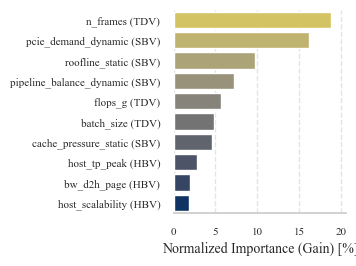

In [22]:
import pandas as pd
import joblib
import json
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb

# --- 1. スタイルの設定（論文全体で統一） ---
# IEEE準拠のフォント設定（Times New Romanが利用可能な場合）
# plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
# plt.rcParams['font.size'] = 12  # 基本フォントサイズ
plt.rcParams['axes.labelsize'] = 10 # 軸ラベルのフォントサイズ
plt.rcParams['xtick.labelsize'] = 8 # X軸目盛り
plt.rcParams['ytick.labelsize'] = 8 # Y軸目盛り


# --- 2. 設定: CTFusionモデルのパス ---
CTFUSION_OUTPUT_DIR = Path("../experiments/outputs/exp001_holdout_ctfusion_20250715_163234")
MODEL_PATH = CTFUSION_OUTPUT_DIR / "models/model_holdout.pkl"
FEATURE_LIST_PATH = CTFUSION_OUTPUT_DIR / "feature_list.json"


# --- 3. 特徴量の表示名マッピング辞書 ---
FEATURE_DISPLAY_NAMES = {
    'interact_data_to_pcie_demand_ratio': 'pcie_demand_dynamic (SBV)', # 以前の pcie_demand_dynamic
    'interact_compute_to_memory_ratio': 'roofline_static (SBV)',      # 以前の roofline_static
    'interact_host_to_gpu_balance_ratio_dynamic': 'pipeline_balance_dynamic (SBV)', # 以前の pipeline_balance_dynamic
    'interact_memory_to_cache_pressure_ratio': 'cache_pressure_static (SBV)',    # 以前の cache_pressure_static

    'host_compute_Image_Preprocessing_Rate_peak_host_throughput': 'host_tp_peak (HBV)', # host_tp_peak
    'host_compute_Image_Preprocessing_Rate_scalability_factor': 'host_scalability (HBV)', # host_scalability
    'data_transfer_D2H_PCIe_peak_bandwidth_gbps': 'bw_d2h_page (HBV)', # bw_d2h_peak の一種として解釈

    # ------------------- モデル固有・タスク固有の特徴量 ----------------
    'total_frames': 'n_frames (TDV)',
    'model_flops_g': 'flops_g (TDV)',
    'batch_size': 'batch_size (TDV)',
    'model_memory_footprint_mb': 'Model Memory (MB)',
}

# --- 4. グラフ作成関数 ---
def create_feature_importance_plot_for_ieee(model_path, feature_list_path):
    """
    モデルと特徴量リストから、論文用の特徴量重要度グラフを作成する関数
    """
    try:
        model = joblib.load(model_path)
        with open(feature_list_path, 'r') as f:
            feature_names = json.load(f)['features']
    except FileNotFoundError as e:
        print(f"エラー: 必要なファイルが見つかりません。パスを確認してください。\n{e}")
        return
    except Exception as e:
        print(f"エラー: ファイルの読み込み中に問題が発生しました。\n{e}")
        return

    if not isinstance(model, lgb.LGBMRegressor):
        print(f"エラー: 読み込まれたモデルの型が不正です (期待: LGBMRegressor, 実際: {type(model)})")
        return

    booster = model.booster_
    importances_gain = booster.feature_importance(importance_type='gain')
    
    df_importance = pd.DataFrame({
        'feature_internal': feature_names,
        'importance_gain': importances_gain
    })
    
    # 重要度を正規化（合計が100%になるように）
    total_gain = df_importance['importance_gain'].sum()
    if total_gain > 0:
        df_importance['importance_normalized'] = (df_importance['importance_gain'] / total_gain) * 100
    else:
        df_importance['importance_normalized'] = 0
    
    # 表示用の特徴量名に変換
    df_importance['feature_display'] = df_importance['feature_internal'].apply(
        lambda x: FEATURE_DISPLAY_NAMES.get(x, x.replace('_', ' ').title()) # マッピングにないものは整形
    )
    
    # 重要度が0より大きい上位10件を抽出
    df_importance_top10 = df_importance[df_importance['importance_normalized'] > 0].sort_values(
        'importance_normalized', ascending=False
    ).head(10)
    
    print("--- Top 10 Feature Importances (Gain, Normalized) ---")
    print(df_importance_top10[['feature_display', 'importance_normalized']].to_string(index=False))
    print("-----------------------------------------------------")
    
    # グラフ描画
    fig, ax = plt.subplots(figsize=(3.4, 2.5)) # IEEEの論文カラム幅に合わせたサイズ例
    
    # Cividisパレットを使用し、順序を反転させて上が明るくなるように
    palette = sns.color_palette("cividis_r", n_colors=len(df_importance_top10))
    
    # [改善点] FutureWarningを解消するため、`hue`にy軸の変数を指定し、`legend=False`を追加
    sns.barplot(
        x='importance_normalized', 
        y='feature_display',
        data=df_importance_top10, 
        hue='feature_display', # y変数をhueに割り当てる
        palette=palette,
        legend=False, # 凡例は不要なため非表示に
        ax=ax
    )
    
    ax.set_xlabel('Normalized Importance (Gain) [%]')
    ax.set_ylabel('') # Y軸のカテゴリ名は特徴量名で十分なため、ラベルは不要
    
    # スタイルの調整
    ax.grid(axis='x', linestyle='--', alpha=0.6, color='lightgrey')
    ax.set_facecolor('white')
    ax.set_xlim(0, df_importance_top10['importance_normalized'].max() * 1.1) # X軸の範囲を調整
    
    # 上と右の枠線を消してスッキリさせる
    sns.despine(left=True, bottom=False)
    
    plt.tight_layout(pad=0.1)
    # ファイルに保存する場合
    # plt.savefig("feature_importance_ieee.pdf", format='pdf', bbox_inches='tight')
    plt.show()

# --- 5. メインの処理 ---
if __name__ == "__main__":
    create_feature_importance_plot_for_ieee(MODEL_PATH, FEATURE_LIST_PATH)



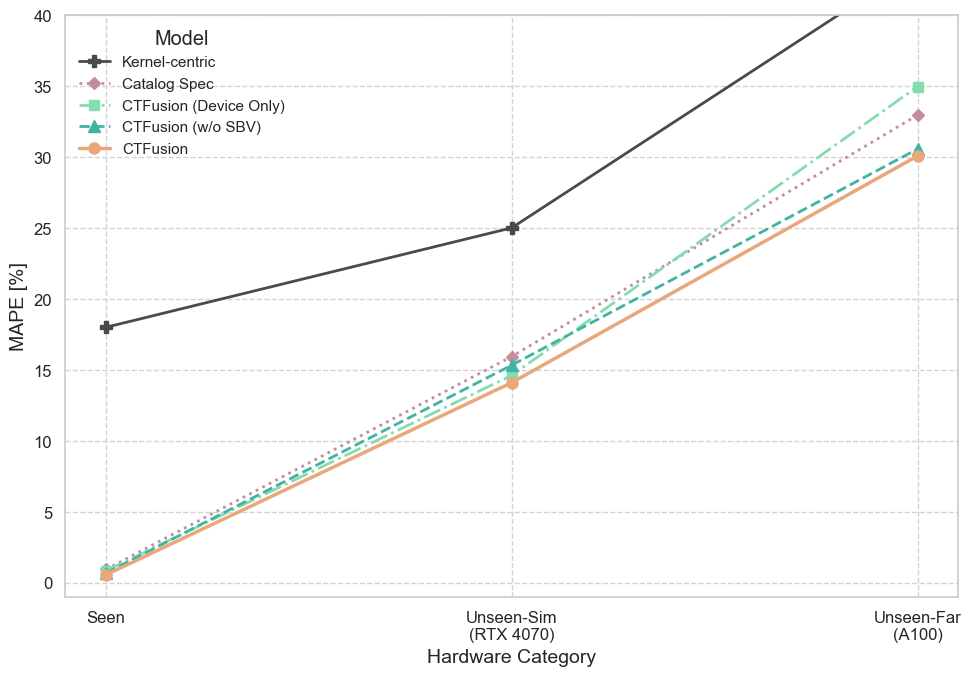

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# --- 1. データを直接入力 ---
data_dict = {
    'Model': [
        'Kernel-centric', 'Kernel-centric', 'Kernel-centric',
        'Catalog Spec', 'Catalog Spec', 'Catalog Spec',
        'CTFusion (Device Only)', 'CTFusion (Device Only)', 'CTFusion (Device Only)',
        'CTFusion (w/o SBV)', 'CTFusion (w/o SBV)', 'CTFusion (w/o SBV)',
        'CTFusion', 'CTFusion', 'CTFusion',
    ],
    'category': [
        'Seen', 'Unseen (RTX 4070)', 'Unseen (A100)', 'Seen', 'Unseen (RTX 4070)', 'Unseen (A100)',
        'Seen', 'Unseen (RTX 4070)', 'Unseen (A100)', 'Seen', 'Unseen (RTX 4070)', 'Unseen (A100)',
        'Seen', 'Unseen (RTX 4070)', 'Unseen (A100)',
    ],
    'MAPE': [
        18.00, 25.01, 43.65, 0.93, 15.94, 32.96, 0.83, 14.61, 34.97,
        0.67, 15.33, 30.57, 0.55, 14.10, 30.08,
    ]
}
df_plot = pd.DataFrame(data_dict)

# モデルの表示順序を定義
MODELS_IN_ORDER = [
    "Kernel-centric",
    "Catalog Spec",
    "CTFusion (Device Only)",
    "CTFusion (w/o SBV)",
    "CTFusion",
]

# --- 2. スタイルマッピングの定義 (色、マーカー、線種) ---
colors = sns.color_palette("cividis", n_colors=len(MODELS_IN_ORDER))

style_map = {
    # 提案手法: 目立つ色
    "CTFusion":               {'color': '#E8A87C', 'marker': 'o', 'linestyle': '-', 'linewidth': 2.5, 'markersize': 8, 'zorder': 10},
    # Ablation Models
    "CTFusion (w/o SBV)":     {'color': '#41B3A3', 'marker': '^', 'linestyle': '--', 'linewidth': 2.0, 'markersize': 8},
    "CTFusion (Device Only)": {'color': '#85DCB0', 'marker': 's', 'linestyle': '-.', 'linewidth': 2.0, 'markersize': 7},
    # Baselines
    "Catalog Spec":           {'color': '#C38D9E', 'marker': 'D', 'linestyle': ':', 'linewidth': 2.0, 'markersize': 6},
    "Kernel-centric":           {'color': '#4A4A4A', 'marker': 'P', 'linestyle': '-', 'linewidth': 2.0, 'markersize': 8}, # zorderで最背面に
}

# --- 3. グラフ描画 ---
fig, ax = plt.subplots(figsize=(10, 7))

# カテゴリの順序とX軸ラベル
x_order = ['Seen', 'Unseen (RTX 4070)', 'Unseen (A100)']
x_labels = ['Seen', 'Unseen-Sim\n(RTX 4070)', 'Unseen-Far\n(A100)']

# 各モデルの線をプロット
for model_name in MODELS_IN_ORDER:
    model_data = df_plot[df_plot['Model'] == model_name].set_index('category').reindex(x_order)
    style = style_map.get(model_name, {}) # スタイルを取得
    
    ax.plot(model_data.index, model_data['MAPE'], label=model_name, **style)

# ★★★ Y軸の範囲を固定し、はみ出す線はクリップする ★★★
ax.set_ylim(-1, 40)
ax.set_yticks(np.arange(0, 41, 5))

# ラベル設定
ax.set_ylabel('MAPE [%]', fontsize=14)
ax.set_xlabel('Hardware Category', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)
ax.set_xticks(x_order)
ax.set_xticklabels(x_labels)

# 凡例をグラフ内の左上に配置
ax.legend(title="Model", loc='upper left', fontsize=11)

# グリッド
ax.grid(True, which="major", ls="--", c="lightgrey")
ax.set_facecolor('white') 
plt.tight_layout()
plt.show()

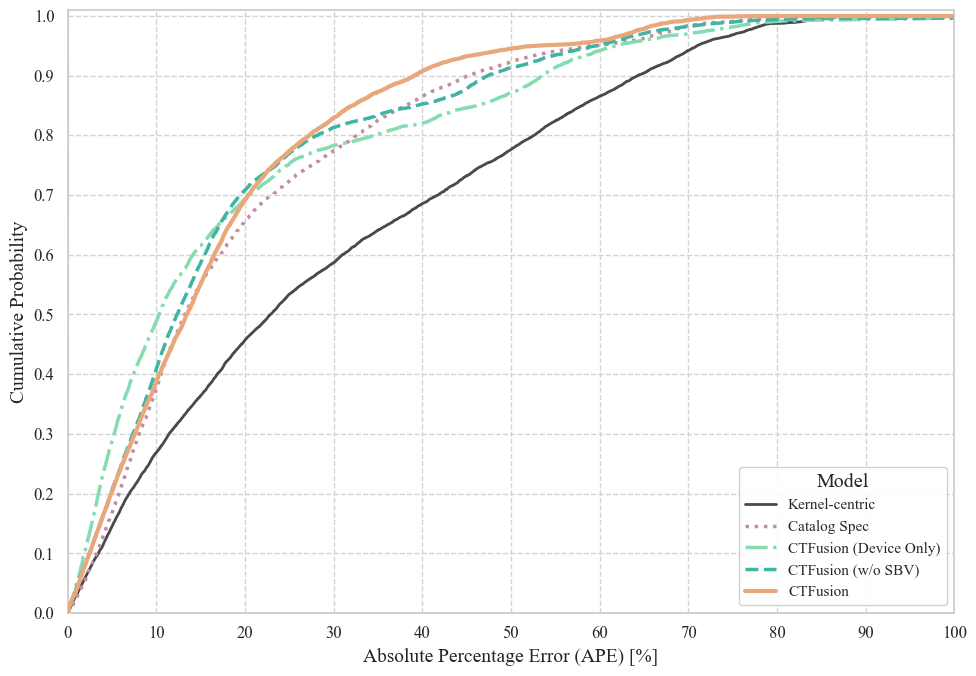

In [ ]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 設定 ---
STGC_EVAL_OUTPUTS_DIR = Path("../experiments/outputs")

# 論文で表示したいモデルの順序を定義
MODELS_IN_ORDER = [
    "Kernel-centric",
    "Catalog Spec",
    "CTFusion (Device Only)",
    "CTFusion (w/o SBV)",
    "CTFusion", # 提案手法を最後に
]

# モデル名とディレクトリのマッピング
MODEL_DIRS = {
    "CTFusion": "exp001_holdout_ctfusion_20250715_163234",
    "Kernel-centric": "exp002_holdout_baseline_kernel_centric_20250721_185505",
    "Catalog Spec": "exp003_holdout_baseline_catalog_spec_20250721_223721",
    "CTFusion (Device Only)": "exp004_holdout_ablation_device_only_20250722_000209",
    "CTFusion (w/o SBV)": "exp005_holdout_ablation_without_interaction_20250721_231059",
}

UNKNOWN_SYSTEMS = [
    "intel_xeon_gold_6330__nvidia_a100_pcie_40gb",  
    "intel_core_i5_13th_gen__nvidia_geforce_rtx_4070",
    "intel_core_i7_9th_gen__nvidia_geforce_rtx_4070",
    "intel_core_i7_13th_gen__nvidia_geforce_rtx_4070", 
    "intel_xeon_gold_5122__nvidia_geforce_rtx_4070",
]
PREDICTIONS_FILENAME = "predictions_all.csv"

# --- 2. 全モデルの予測データを読み込み、結合 ---
all_preds_list = []
for model_name in MODELS_IN_ORDER:
    output_dir = MODEL_DIRS.get(model_name)
    if not output_dir:
        print(f"警告: モデル '{model_name}' のディレクトリ設定が見つかりません。")
        continue
    
    path = STGC_EVAL_OUTPUTS_DIR / output_dir / PREDICTIONS_FILENAME
    if path.exists():
        df = pd.read_csv(path)
        df['Model'] = model_name
        all_preds_list.append(df)
    else:
        print(f"警告: {path} が見つかりません。スキップします。")

if not all_preds_list:
    print("エラー: 評価対象の予測ファイルが一つも見つかりませんでした。")
    exit()

df_all = pd.concat(all_preds_list, ignore_index=True)
df_all['ape_pct'] = df_all['ape'] * 100


# --- 3. 詳細評価テーブル (カテゴリ別) の作成と表示 ---
# カテゴリ分け
df_all['category'] = np.where(df_all['system_id'].isin(UNKNOWN_SYSTEMS), 'Unseen', 'Seen')
df_all.loc[(df_all['category'] == 'Unseen') & (df_all['system_id'].str.contains('a100')), 'category'] = 'Unseen (A100)'
df_all.loc[(df_all['category'] == 'Unseen') & (df_all['system_id'].str.contains('rtx_4070')), 'category'] = 'Unseen (RTX 4070)'


df_unseen = df_all[df_all['category'].str.startswith('Unseen')]

# --- 2. スタイルマッピングの定義（折れ線グラフと完全に統一） ---
style_map = {
    # 提案手法: 目立つ色 (zorderで最前面に)
    "CTFusion":               {'color': '#E8A87C', 'linestyle': '-', 'linewidth': 3.0, 'zorder': 10},
    # Ablation Models
    "CTFusion (w/o SBV)":     {'color': '#41B3A3', 'linestyle': '--', 'linewidth': 2.5},
    "CTFusion (Device Only)": {'color': '#85DCB0', 'linestyle': '-.', 'linewidth': 2.5},
    # Baselines
    "Catalog Spec":           {'color': '#C38D9E', 'linestyle': ':', 'linewidth': 2.5},
    "Kernel-centric":         {'color': '#4A4A4A', 'linestyle': '-', 'linewidth': 2.0},
}

# --- 3. CDFグラフ描画 ---
fig, ax = plt.subplots(figsize=(10, 7))

# 各モデルのCDFをプロット
for model_name in MODELS_IN_ORDER:
    # スタイルを取得（マーカーはCDFでは使わないので除外）
    current_style = {k: v for k, v in style_map.get(model_name, {}).items() if k != 'marker'}

    # モデルのAPEデータを取得し、ソート
    ape_data = df_unseen[df_unseen['Model'] == model_name]['ape_pct']
    sorted_data = np.sort(ape_data)
    
    # yvals（累積確率）を計算
    yvals = np.arange(1, len(sorted_data) + 1) / len(sorted_data)
    
    # プロット
    ax.plot(sorted_data, yvals, label=model_name, **current_style)

# --- 4. グラフのフォーマット調整（論文品質） ---
# 軸ラベル
ax.set_ylabel('Cumulative Probability', fontsize=14)
ax.set_xlabel('Absolute Percentage Error (APE) [%]', fontsize=14)
ax.tick_params(axis='both', which='major', labelsize=12)

# 軸の範囲と目盛り
ax.set_xlim(0, 100)
ax.set_ylim(0, 1.01)
ax.set_xticks(np.arange(0, 101, 10))
ax.set_yticks(np.arange(0, 1.1, 0.1))

# 凡例を最適な位置（右下）に配置
ax.legend(title="Model", loc='lower right', fontsize=11, frameon=True, framealpha=0.9)

# グリッド
ax.grid(True, which="major", ls="--", c="lightgrey")
ax.set_facecolor('white')

# レイアウトを整える
plt.tight_layout()
plt.show()